In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
import pandas
from qutip import*

In [11]:
# defining some constants
# h = 4.135667696 eV.fs 
# E = hf = hcf/c = hcv where v is the frequency in wavenumber. This eq gives energy in eV from freq in 1/cm.
# c needs to be in cm/fs, c=299792458 m/s = 2.99792458E8 * E-15 * E2 cm/fs = 2.99792458E-5 cm/fs

# units: Energy E = eV,
# freq. v = 1/cm,
# speed of light c = cm/fs,
# h = eV.fs
# time = fs but there is a factor of 2pi since the energies are in hcv and the time-evolution of S.E. has exp(-iEt/hbar)

h_0 = 4.135667696
c = 2.99792458E-5
h = h_0*c
vb_all_ref = [[14750, 14699, 14700], [14840, 14751, 14770], [14860, 14804, 
  14810], [14860, 14858, 14880], [14880, 14918, 14910], [14900, 14952, 14990], [14990, 14992, 15030], [15040, 15022, 
  15130], [15175, 15210, 15210], [15290, 15306, 15290], [15400, 15363, 15360], [15400, 15416, 15430], [15555, 15456, 
  15480], [15650, 15512, 15510]]
vb = []
for x in range(len(vb_all_ref)):
    vb.append(np.mean(vb_all_ref[x]))
    
t = pandas.read_csv('LHCII_couplings.csv')
t

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,36.0,-5.0,-3.0,1.0,-2.0,-3.0,3.0,4.0,-5.0,20.0,2.0,-8.0,2.0
1,0.0,0.0,15.0,6.0,0.0,5.0,6.0,-6.0,-24.0,-5.0,1.0,8.0,-2.0,0.0
2,0.0,0.0,0.0,-1.0,0.0,-4.0,6.0,4.0,72.0,7.0,-1.0,1.0,1.0,-5.0
3,0.0,0.0,0.0,0.0,4.0,71.0,24.0,-4.0,-2.0,0.0,-3.0,3.0,2.0,-3.0
4,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,-4.0,0.0,1.0,1.0,-2.0,-1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,16.0,-5.0,2.0,0.0,-2.0,2.0,2.0,-2.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,-5.0,1.0,-2.0,3.0,3.0,-3.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,43.0,5.0,-1.0,-2.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,4.0,-2.0,-2.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-26.0,13.0,6.0,-1.0


In [12]:
class system:
    def __init__(self, total_photons,nphoton,nsite,g,u):
        # total_photons is the max number of photons that can be put in any subsystem
        # nphoton is the number of photons in the starting fock state for the cavity mode.
        # nsite is the number of sites you want to put in the system
        # g is the cavit-site coupling in wavenumbers (1/cm)
        # u is the site anharmonicity (energy cost) in wavenumbers (1/cm)
        
        self.total_photons = total_photons
        self.nphoton = nphoton
        self.nsite = nsite
        self.g = g
        self.u = u
        self.state = 'state not defined yet'
        self.H0 = 'H0 not defined here yet'
        self.Hint = 'Hint not defined yet'
        self.a = 'cavity destroy not defined yet'
        self.b = 'site destroy list not defined yet'
        
        self.set_state(self.nphoton)
        self.set_hamiltonian_and_operators()
        
    
    def set_state(self,nphoton):
        self.nphoton = nphoton
        nSubSystems = [self.total_photons+1] # creating a list like [n,n,n,...] so that we can tell the dimensions to enr_destroy function
        number_state = [self.nphoton]
        for k in range(self.nsite):
            nSubSystems.append(self.total_photons+1)
            number_state.append(0)
        number_state = tuple(number_state)
        print('the state name is ',number_state)
        psi = enr_fock(nSubSystems,self.total_photons,number_state)
        self.state = psi
        return psi
    
    # The function below, will be developed and used in future. 
    
    def coherent_state(self,nphoton):
        return None
    def thermal_state(self,nphoton):
        return None
    
    
    # Now defining Hamiltonian and other operators
    def set_hamiltonian_and_operators(self):

        nSubSystems = [] # creating a list like [n,n,n,...] so that we can tell the dimensions to enr_destroy function
        for k in range(self.nsite+1):
            nSubSystems.append(self.total_photons+1)

        all_ops = enr_destroy(nSubSystems,excitations=self.total_photons)
        self.a = all_ops[0]
        self.b = all_ops[1:]

        if self.nsite==1:
            vc = vb[0]
            print('frequencies are ', 'cavity ', vc, 'Site ',vb[0])
            self.H0 = h*vc*self.a.dag()*self.a + h*vb[0]*self.b[0].dag()*self.b[0]   # cavity and site energies
            self.Hint = h*self.g*(self.a.dag()*self.b[0] + self.b[0].dag()*self.a) # cavity site Interaction
            # Notice that there is no anharmonicity in this simple system.

        else:
            vc = (vb[0]+vb[self.nsite-1])/2# setting the cav freq to mean of LHII freq range
            print('frequencies are ', 'cavity ', vc, 'First site ',vb[0], 'Last site ', vb[self.nsite-1])

            # First Creating basic hamiltonian
            print('Creating Basic Hamiltonian')
            self.H0 = h*vc*self.a.dag()*self.a   # cavity only
            # Now adding sites
            for m in range(self.nsite):
                name='b'+str(m+1)
                print('adding site energy for ', name)
                b_op = all_ops[m+1]
                self.H0 = self.H0 + h*vb[m]*b_op.dag()*b_op

            # Now Creating Interaction hamiltonian
            print('Now creating Interaction Hamiltonian')
            self.Hint = self.H0-self.H0
            for m in range(self.nsite):
                name='b'+str(m+1)
                print('adding site cavity and anharmonicity for ', name)
                b_op = all_ops[m+1]
                self.Hint = self.Hint + h*self.g*(self.a.dag()*b_op+self.a*b_op.dag())+h*self.u*(b_op.dag()*b_op.dag()*b_op*b_op)
            # adding hopping between sites
            for m in range(self.nsite-1):
                name1='b'+str(m+1)
                #print('first',name)
                b_op1 = all_ops[m+1]
                for k in range(m+1,self.nsite):
                    name2 = 'b'+str(k+1)
                    #print('second',name2)
                    b_op2 = all_ops[k+1]
                    print('adding hopping between sites: ', name1, name2, ' hopping freq t= ', t.iat[m,k])
                    self.Hint = self.Hint+ h*t.iat[m,k]*(b_op1.dag()*b_op2+b_op2.dag()*b_op1)
            print('shape of interaction hamiltonian is', self.Hint.shape)


        return self.H0,self.Hint,self.a,self.b

In [126]:
s = system(2,2,2,30,50)

the state name is  (2, 0, 0)
frequencies are  cavity  14751.666666666668 First site  14716.333333333334 Last site  14787.0
Creating Basic Hamiltonian
adding site energy for  b1
adding site energy for  b2
Now creating Interaction Hamiltonian
adding site cavity and anharmonicity for  b1
adding site cavity and anharmonicity for  b2
adding hopping between sites:  b1 b2  hopping freq t=  36.0
shape of interaction hamiltonian is (10, 10)


In [127]:
s.state

Quantum object: dims = [[3, 3, 3], [1, 1, 1]], shape = (10, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

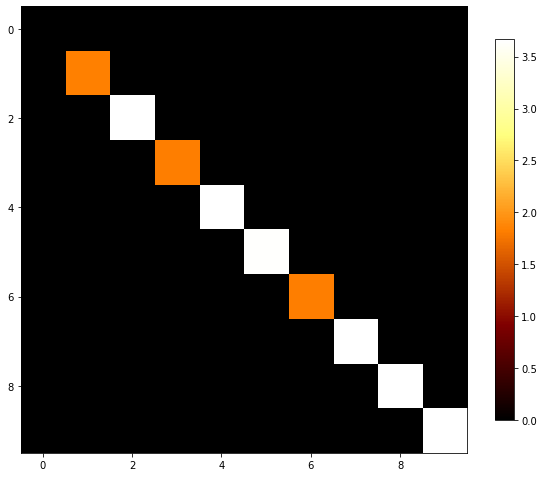

In [128]:
plt.figure(figsize=(10,10))
plt.imshow(np.real(s.H0),cmap='afmhot')
plt.colorbar(shrink=0.7)
plt.show()

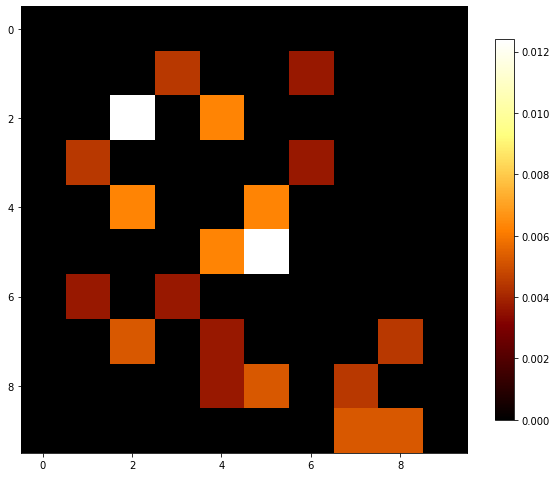

In [129]:
plt.figure(figsize=(10,10))
plt.imshow(np.real(s.Hint),cmap='afmhot')
plt.colorbar(shrink=0.7)
plt.show()

In [130]:
op_list = [s.a.dag()*s.a]
for k in range(len(s.b)):
    op = s.b[k]
    op_list.append(op.dag()*op)

psi_dm = s.state*s.state.dag()
kappa= 0.05**2 # this is the leakage rate, remember the time here is in fs.
c_ops = [np.sqrt(kappa)*s.a] # just one collapse operator i.e. the leakage rate.



In [131]:
 # time in this simulation is in fs.
tlist = np.linspace(0,4000,4000)
options = Options(store_states = False)
results = mesolve(s.H0+s.Hint, psi_dm, tlist, c_ops, op_list,{},options)

Text(0, 0.5, '<N>')

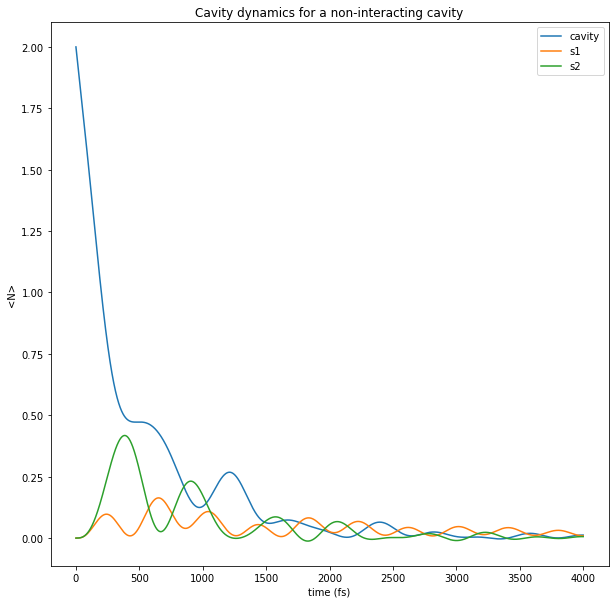

In [132]:
plt.figure(figsize=(10,10))

for m in range(len(results.expect)):
    plt.plot(tlist, results.expect[m])

plt.legend(['cavity','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14'])
plt.title('Cavity dynamics for a non-interacting cavity')
plt.xlabel('time (fs)')
plt.ylabel('<N>')
#plt.savefig('Non-interacting cavity-Full LHII-kappa 5 percent')

Text(0, 0.5, '<N>')

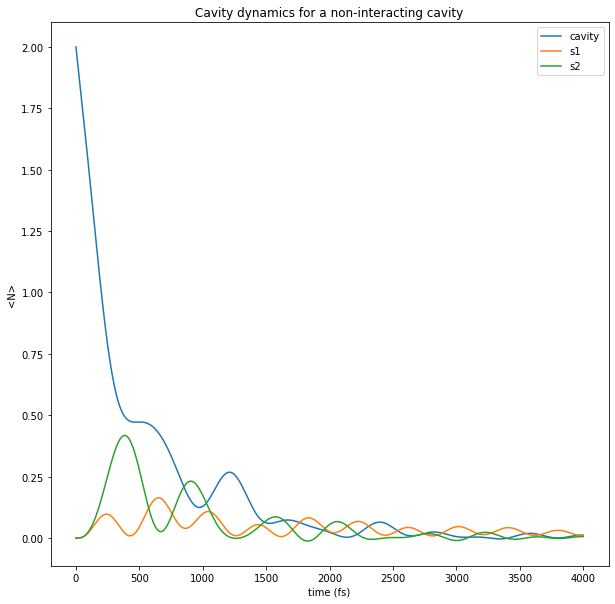

In [118]:
#qsave(results,'pop for non-interacting cavity-Full LHII- kappa 5 percent')

In [133]:
n_pop = results.expect[0]
G1 = correlation_2op_1t(s.H0+s.Hint, psi_dm, tlist, c_ops, s.a.dag(), s.a)
g1 = G1 / np.sqrt(n_pop[0] * n_pop)

/home/nyoun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'g1')

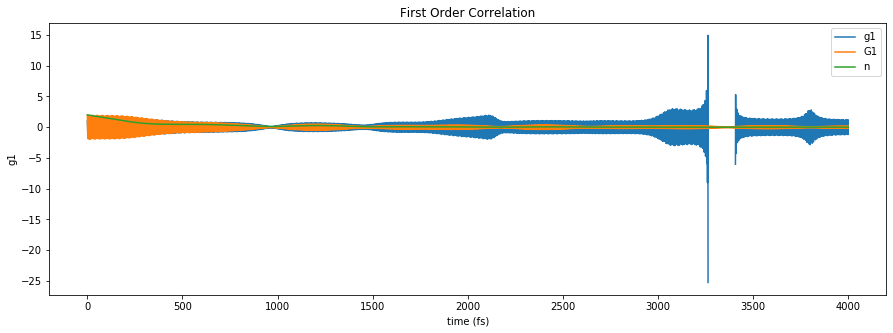

In [134]:

plt.figure(figsize=(15, 5))
plt.plot(tlist,np.real(g1))
plt.plot(tlist,G1)
plt.plot(tlist,n_pop)
plt.legend(['g1','G1','n'])
plt.title('First Order Correlation')
plt.xlabel('time (fs)')
plt.ylabel('g1')
#plt.savefig('g1 for non-interacting cavity-full LHII-kappa 5 percent')

Text(0, 0.5, 'g1')

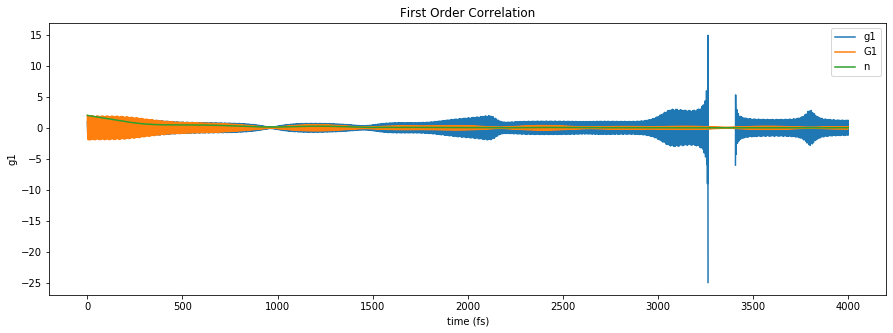

In [121]:
#qsave(g1,'g1 for non-interacting cavity-full LHII-kappa 5 percent')

<function matplotlib.pyplot.show(*args, **kw)>

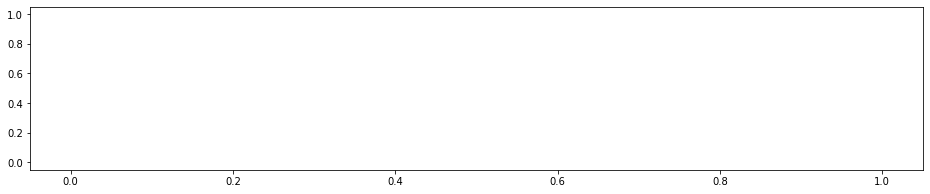

In [135]:
[w, gf] = spectrum_correlation_fft(tlist,np.real(g1))
f = w/(c)
plt.figure(figsize=(16,3))
plt.plot(f,gf)
plt.show

In [136]:
n_pop = results.expect[0]
G2 = correlation_3op_1t(s.H0+s.Hint, psi_dm, tlist, c_ops, s.a.dag(), s.a.dag()*s.a, s.a)
g2 = G2 /(n_pop[0] * n_pop)
#qsave(g2,'g2 for non-interacting cavity-full LHII-kappa 5 percent')

Text(0, 0.5, 'g2')

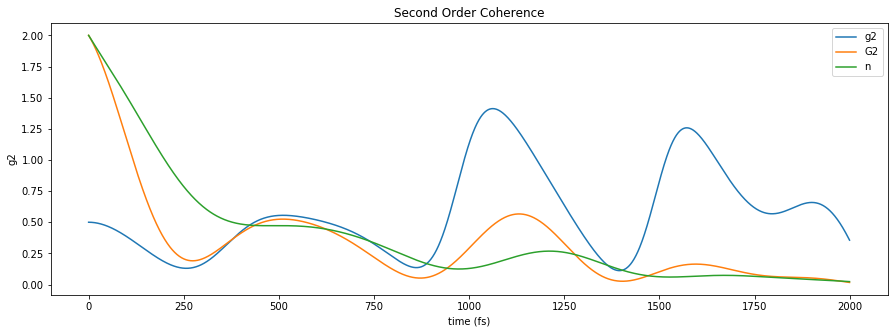

In [137]:
T = int(len(tlist)/2)
plt.figure(figsize=(15, 5))
plt.plot(tlist[:T],np.real(g2)[:T])
plt.plot(tlist[:T],G2[:T])
plt.plot(tlist[:T],n_pop[:T])
plt.legend(['g2','G2','n'])
plt.title('Second Order Coherence')
plt.xlabel('time (fs)')
plt.ylabel('g2')
#plt.savefig('g2 for non-interacting cavity-full LHII-kappa 5 percent')

Text(0, 0.5, 'g2')

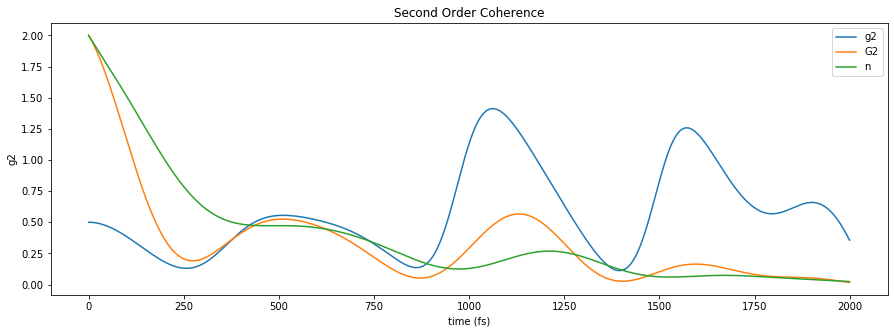

In [ ]:
[energies,states] = H0.eigenstates()
H = H0.transform(states) # H is in polariton basis now
op_list = []
for k in range(15):
    op = all_ops[k]
    op = op.transform(states) # each operator is in polariton basis now
    op_list.append(op.dag()*op)

n=3
psi = enr_fock([n,n,n,n,n,n,n,n,n,n,n,n,n,n,n], 2, [2,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
psi_dm = psi*psi.dag()
psi_dm = psi_dm.transform(states) #density matrix is in polariton basis now
gamma = 0.05
c_ops = [gamma*a.transform(states)] # collaps operator is in polariton basis now. 
energies.size

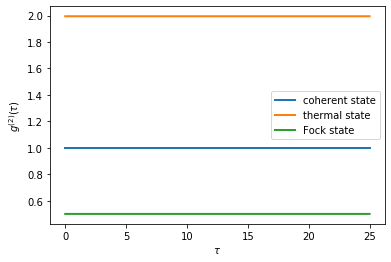

In [32]:
import numpy as np
import pylab as plt
from qutip import *

N = 25
taus = np.linspace(0, 25.0, 200)
a = destroy(N)
H = 2 * np.pi * a.dag() * a

kappa = 0.25
n_th = 2.0  # bath temperature in terms of excitation number
c_ops = [np.sqrt(kappa) * a]

states = [{'state': coherent_dm(N, np.sqrt(2)), 'label': "coherent state"},
          {'state': thermal_dm(N, 2), 'label': "thermal state"},
          {'state': fock_dm(N, 2), 'label': "Fock state"}]

fig, ax = plt.subplots(1, 1)

for state in states:
    rho0 = state['state']

    # first calculate the occupation number as a function of time
    n = mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]

    # calculate the correlation function G2 and normalize with n(0)n(t) to
    # obtain g2
    G2 = correlation_3op_1t(H, rho0, taus, c_ops, a.dag(), a.dag()*a, a)
    g2 = G2 / (n[0] * n)

    ax.plot(taus, np.real(g2), label=state['label'], lw=2)

ax.legend(loc=0)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
plt.show()